# Classical and Quantum case

Incidentally the non classical part vanishes when we consider the expectation value on the computational basis of the transverse field

\begin{equation}
\langle\sigma_i|\hat\sigma^x|\sigma_i\rangle=0
\end{equation}

So when we consider the expectation value of energy, only the "classical" part contributes

\begin{equation}
\langle\sigma_i|\hat H|\sigma_i\rangle=\langle\sigma_i|J \sum \hat \sigma_i^z\hat\sigma^z_{i+1}|\sigma_i\rangle
\end{equation}

And it "counts" the number of disaligned pairs, just as the classical version, in the limit of no external field 

From a mathematical point of view we are actually computing two different values

\begin{equation}
e^{\langle\sigma_i|\hat H|\sigma_i\rangle}\neq\langle\sigma_i|e^{-\beta \hat H}|\sigma_i\rangle
\end{equation}

When $| \sigma_i \rangle$ are auto-state of the hamiltonian, this two values coincides

From a physical point of view we are considering two systems, a quantistic one with transverse field and a classic one with no external field

In [2]:
import numpy as np
from numpy import linalg
from scipy import linalg
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp


from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

from scipy.linalg import expm
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Kraus, SuperOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise

from qiskit.quantum_info import Statevector

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit.opflow import Z, I, X, Zero, One
from qiskit.circuit.library import EfficientSU2

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit import IBMQ, Aer
from qiskit_aer.noise import NoiseModel

from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

from numpy import pi, array,sqrt,exp,savetxt,loadtxt

from qiskit.providers.fake_provider import FakeManila

from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex
from qiskit import QuantumRegister

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import CircuitSampler, StateFn

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import phase_amplitude_damping_error

import matplotlib.pyplot as plt

In [3]:
#First we write the function for Ising hamiltonian
#We use qubits to represent sites

def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    return hamiltonian

In [16]:
#Fix temperature at 300K
#We fix k_b in electronvolt; we didn't put units in hamiltonian

T=3000
k=8.6*10**(-5)
beta=(k*T)**(-1)

nShots = 8192
J = -1
b = 4
num_qubits=4

In [32]:
h=H_ising(num_qubits,J,b)

In [18]:
#Build computational basis

basis=[]

n=num_qubits-1

for k in range(2**num_qubits):
    basis.append(Zero if k%2==0 else One)

for i in range (2**num_qubits):
    if (i)%4==0:
        basis[i]=Zero^basis[i]
    elif (i)%4==1:
         basis[i]=Zero^basis[i]
    else:
        basis[i]=One^basis[i]

for i in range (2**num_qubits):
    if (i)%8==0:
         basis[i]=Zero^basis[i]
    elif (i)%8==1:
         basis[i]=Zero^basis[i]
    elif (i)%8==2:
        basis[i]=Zero^basis[i]
    elif (i)%8==3:
        basis[i]=Zero^basis[i]
    else:
        basis[i]=One^basis[i]

for i in range (2**n):
    basis[i]=Zero^basis[i]
    
for i in range (2**n,2**num_qubits):
    basis[i]=One^basis[i]

In [45]:
#Evaluate energy mean value 
E=[]

for i in range(0,3,1):
    h=H_ising(num_qubits,J,i)
    for k in range(2**num_qubits):
        E.append((~basis[k] @ h @ basis[k]).eval())
    print("Energy Mean:\n")
    for n in range(2**num_qubits):
        print("State",n,E[n])
    


Energy Mean:

State 0 (-3+0j)
State 1 (-1+0j)
State 2 (1+0j)
State 3 (-1+0j)
State 4 (1+0j)
State 5 (3+0j)
State 6 (1+0j)
State 7 (-1+0j)
State 8 (-1+0j)
State 9 (1+0j)
State 10 (3+0j)
State 11 (1+0j)
State 12 (-1+0j)
State 13 (1+0j)
State 14 (-1+0j)
State 15 (-3+0j)
Energy Mean:

State 0 (-3+0j)
State 1 (-1+0j)
State 2 (1+0j)
State 3 (-1+0j)
State 4 (1+0j)
State 5 (3+0j)
State 6 (1+0j)
State 7 (-1+0j)
State 8 (-1+0j)
State 9 (1+0j)
State 10 (3+0j)
State 11 (1+0j)
State 12 (-1+0j)
State 13 (1+0j)
State 14 (-1+0j)
State 15 (-3+0j)
Energy Mean:

State 0 (-3+0j)
State 1 (-1+0j)
State 2 (1+0j)
State 3 (-1+0j)
State 4 (1+0j)
State 5 (3+0j)
State 6 (1+0j)
State 7 (-1+0j)
State 8 (-1+0j)
State 9 (1+0j)
State 10 (3+0j)
State 11 (1+0j)
State 12 (-1+0j)
State 13 (1+0j)
State 14 (-1+0j)
State 15 (-3+0j)


In [44]:
h1=Operator(h)
expmatrix=linalg.expm(-beta*h1)
trace=expmatrix.trace()
density=qi.DensityMatrix(expmatrix/trace)
densityOp=Operator(density)

density.draw('latex', prefix='\\rho_{\\beta} = ')

<IPython.core.display.Latex object>

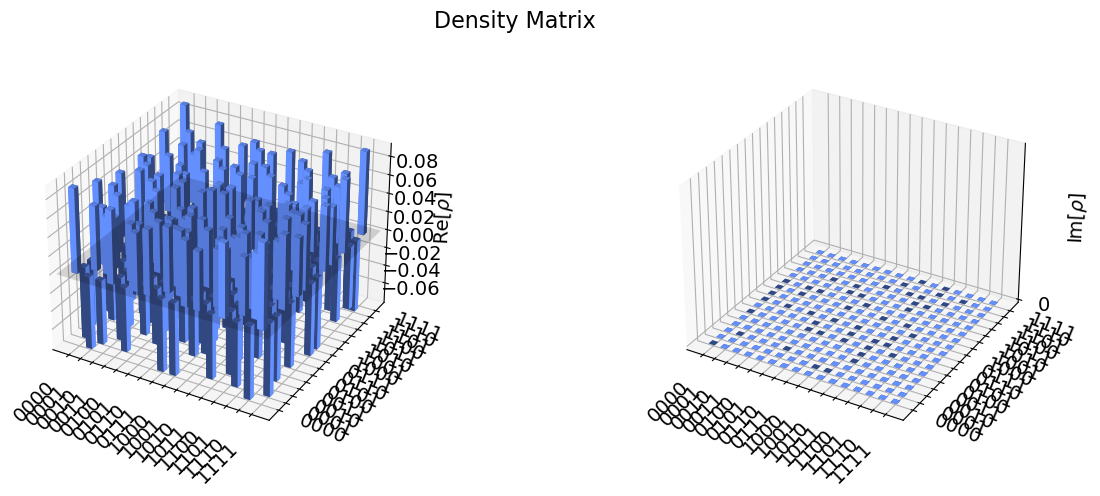

In [26]:
from qiskit.visualization import plot_state_city
plot_state_city(density.data, title='Density Matrix')

In [30]:
h=H_ising(num_qubits,J,0)

In [29]:
h1=Operator(h)
expmatrix=linalg.expm(-beta*h1)
trace=expmatrix.trace()
density=qi.DensityMatrix(expmatrix/trace)
densityOp=Operator(density)


density.draw('latex', prefix='\\rho_{\\beta} = ')



<IPython.core.display.Latex object>

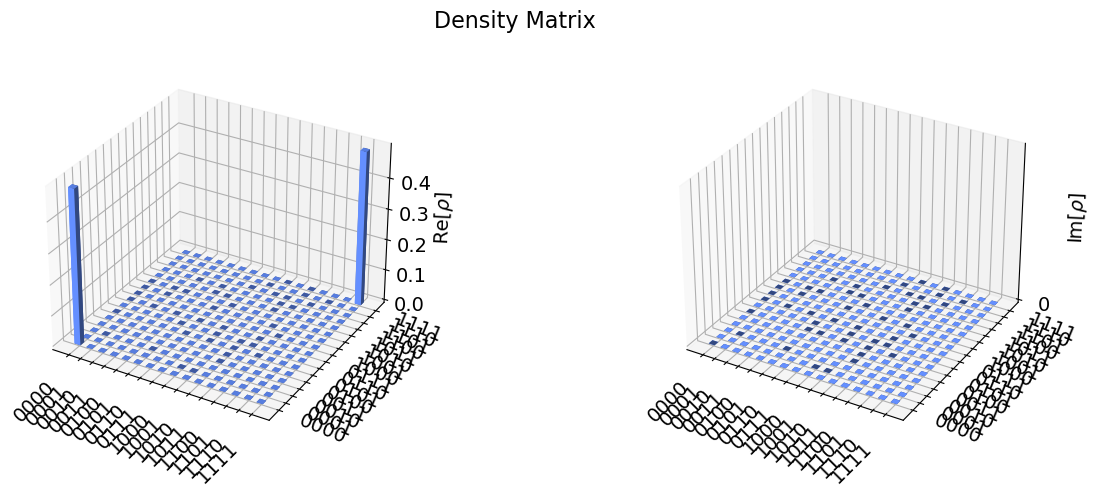

In [31]:
from qiskit.visualization import plot_state_city
plot_state_city(density.data, title='Density Matrix')